### Data Files:
<ul>
    <li>calls.csv: a timeline of outgoing sales calls and the disposition of those calls</li>
    <li>events.csv: any activities that we have on record taking place before the phone calls were made</li>
    <li>companies.csv: the industry and employee count of the companies</li>
    <li>people.csv: the people who were called, along with their job level and function and the ID of the company they work for</li>
    <li>opportunities.csv: the date an opportunity was generated for a contact</li>
</ul>

## Import Data

In [228]:
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.model_selection import train_test_split

import sklearn

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, KBinsDiscretizer, FunctionTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

# import xgboost as xgb

In [229]:
events = pd.read_csv("../data/6Sense/events.csv")
calls = pd.read_csv("../data/6Sense/calls.csv")
companies = pd.read_csv("../data/6Sense/companies.csv")
people = pd.read_csv("../data/6Sense/people.csv")
opportunities = pd.read_csv("../data/6Sense/opportunities.csv")
events = events.rename(columns={"date": "event_date"})
calls = calls.rename(columns={"timestamp": "call_time"})
del calls['date']

## Data Cleaning

#### Events
#### Create 'new_events' table with the following columns: 
- Unique contact id
- Total Number of events for each contact_id
- column for each activity_type and the count of that activity
- Date of most recent activity
- Column for month, day of week, week in year, day in month, hour in day, minute

#### Notes:  

- dealing with multiple activities for a single contact_id: keep most recent date event was accessed and the number of times ech activity_type was accessed 

In [230]:
events['event_date'] =  pd.to_datetime(events['event_date'])
events_new = events[["contact_id", "activity_type", 'event_date']].groupby(["contact_id", "activity_type"]).count().rename(columns={"event_date":"event_count"}).unstack(level=-1).fillna(0).reset_index()
events_new.columns = events_new.columns.droplevel(0)
events_new = events_new.rename(columns={"":"contact_id"})
events_new.columns.name = None
events_new["total_activity_count"] = events_new.sum(axis=1)
most_recent = events[["contact_id", 'event_date']].groupby(['contact_id']).agg(lambda x: max(x)).reset_index()["event_date"]
events_new["most_recent_date"] = most_recent

events_new

,contact_id,attended_event,attended_webinar,email_click,email_open,form_fill,known_web_visit,total_activity_count,most_recent_date
0,400b7c0c69474b4cb,0.0,0.0,0.0,5.0,0.0,0.0,5.0,2019-11-14
1,406765c854b7caa84,0.0,0.0,1.0,5.0,1.0,1.0,8.0,2019-10-15
2,406a898980508007b,0.0,0.0,0.0,6.0,0.0,0.0,6.0,2019-11-14
3,40885b79a0c75b87,0.0,0.0,0.0,0.0,1.0,0.0,1.0,2019-08-05
4,40a66aa078a8059b8,0.0,0.0,0.0,1.0,0.0,0.0,1.0,2019-09-28
...,...,...,...,...,...,...,...,...,...
503,cbc060c06674b4cc6,0.0,0.0,0.0,1.0,0.0,0.0,1.0,2019-10-16
504,cc05c95c49b4406b8,0.0,0.0,0.0,1.0,0.0,0.0,1.0,2019-08-16
505,cc457cb5a64a05576,0.0,0.0,0.0,7.0,0.0,0.0,7.0,2019-11-23
506,cc790a6aac6abb064,0.0,0.0,0.0,1.0,0.0,0.0,1.0,2019-11-04


#### Calls
#### Create 'new_calls' table with the following columns: 
- Unique contact id
- Total Number of calls for each contact_id
- Number of successful calls and non successful calls for each contact
- Most recent call

#### Notes:  

- Successful call = "Connected"
- Unsuccessful call = ['Left Voicemail', 'No Answer', 'Wrong Number','Not in Service', 'Busy', 'Rejected']

#### Counts of each type of call disposition
Should we remove the Wrong Number and Not in Service calls?

In [231]:
calls['call_disposition'].value_counts()

No Answer         1192
Left Voicemail    1014
Wrong Number       229
Connected          201
Not in Service      97
Busy                29
Rejected            16
Name: call_disposition, dtype: int64

In [232]:
new_calls = calls.copy()
new_calls['call_time'] =  pd.to_datetime(new_calls['call_time'])
not_successful = ['Left Voicemail', 'No Answer', 'Wrong Number','Not in Service', 'Busy', 'Rejected']
new_calls["call_disposition"] = ["total_no_success" if x in not_successful else "total_success" for x in new_calls['call_disposition']]

new_calls = new_calls.groupby(["contact_id", "call_disposition"]).count().rename(columns={"call_time":"call_count"}).unstack(level=-1).fillna(0).reset_index()
new_calls.columns = new_calls.columns.droplevel(0)
new_calls = new_calls.rename(columns={"":"contact_id"})
new_calls.columns.name = None
new_calls["total_calls_count"] = new_calls.sum(axis=1)
most_recent = calls[["contact_id", 'call_time']].groupby(['contact_id']).agg(lambda x: max(x)).reset_index()["call_time"]
new_calls["most_recent_call"] = most_recent
new_calls


,contact_id,total_no_success,total_success,total_calls_count,most_recent_call
0,40075bbcbc7cc6a44,0.0,1.0,1.0,2019-10-15T20:54:53.000Z
1,400b7c0c69474b4cb,0.0,1.0,1.0,2019-11-25T20:01:44.000Z
2,4044544cb90caaa68,1.0,0.0,1.0,2019-12-17T17:22:24.000Z
3,4048985b7b5958bcb,1.0,0.0,1.0,2019-08-08T18:56:23.000Z
4,40549894a7a40cc68,0.0,1.0,1.0,2019-05-01T15:39:57.000Z
...,...,...,...,...,...
1841,cc9c88409498a6596,1.0,0.0,1.0,2019-07-24T23:29:33.000Z
1842,cca95c8c550099600,1.0,1.0,2.0,2019-09-09T14:57:05.000Z
1843,ccac5bb5608b6c504,1.0,0.0,1.0,2019-03-21T21:34:38.000Z
1844,ccb9054a8507c7b84,1.0,0.0,1.0,2019-07-03T21:27:53.000Z


#### Calls merge left on Events
We get 508 non nulls out of 1846 rows
code: new_calls.merge(events_new, on='contact_id', how='left').info()

In [233]:
call_events = new_calls.merge(events_new, on='contact_id', how='inner')
call_events.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 508 entries, 0 to 507
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   contact_id            508 non-null    object        
 1   total_no_success      508 non-null    float64       
 2   total_success         508 non-null    float64       
 3   total_calls_count     508 non-null    float64       
 4   most_recent_call      508 non-null    object        
 5   attended_event        508 non-null    float64       
 6   attended_webinar      508 non-null    float64       
 7   email_click           508 non-null    float64       
 8   email_open            508 non-null    float64       
 9   form_fill             508 non-null    float64       
 10  known_web_visit       508 non-null    float64       
 11  total_activity_count  508 non-null    float64       
 12  most_recent_date      508 non-null    datetime64[ns]
dtypes: datetime64[ns](1)

In [234]:
call_events

,contact_id,total_no_success,total_success,total_calls_count,most_recent_call,attended_event,attended_webinar,email_click,email_open,form_fill,known_web_visit,total_activity_count,most_recent_date
0,400b7c0c69474b4cb,0.0,1.0,1.0,2019-11-25T20:01:44.000Z,0.0,0.0,0.0,5.0,0.0,0.0,5.0,2019-11-14
1,406765c854b7caa84,2.0,0.0,2.0,2019-10-15T14:17:35.000Z,0.0,0.0,1.0,5.0,1.0,1.0,8.0,2019-10-15
2,406a898980508007b,2.0,0.0,2.0,2019-12-10T14:55:53.000Z,0.0,0.0,0.0,6.0,0.0,0.0,6.0,2019-11-14
3,40885b79a0c75b87,1.0,0.0,1.0,2019-09-18T20:44:27.000Z,0.0,0.0,0.0,0.0,1.0,0.0,1.0,2019-08-05
4,40a66aa078a8059b8,1.0,0.0,1.0,2019-10-21T21:26:58.000Z,0.0,0.0,0.0,1.0,0.0,0.0,1.0,2019-09-28
...,...,...,...,...,...,...,...,...,...,...,...,...,...
503,cbc060c06674b4cc6,1.0,0.0,1.0,2019-12-10T20:15:14.000Z,0.0,0.0,0.0,1.0,0.0,0.0,1.0,2019-10-16
504,cc05c95c49b4406b8,1.0,0.0,1.0,2019-09-25T20:49:30.000Z,0.0,0.0,0.0,1.0,0.0,0.0,1.0,2019-08-16
505,cc457cb5a64a05576,1.0,0.0,1.0,2019-11-25T23:22:17.000Z,0.0,0.0,0.0,7.0,0.0,0.0,7.0,2019-11-23
506,cc790a6aac6abb064,0.0,2.0,2.0,2019-12-13T17:59:35.000Z,0.0,0.0,0.0,1.0,0.0,0.0,1.0,2019-11-04


#### Add binary output 'picked_up_call' 
Successful call = 1      

Unsuccessful call = 0

In [235]:
call_events["picked_up_call"] = [1 if x>=1 else 0 for x in call_events['total_success']]
call_events

,contact_id,total_no_success,total_success,total_calls_count,most_recent_call,attended_event,attended_webinar,email_click,email_open,form_fill,known_web_visit,total_activity_count,most_recent_date,picked_up_call
0,400b7c0c69474b4cb,0.0,1.0,1.0,2019-11-25T20:01:44.000Z,0.0,0.0,0.0,5.0,0.0,0.0,5.0,2019-11-14,1
1,406765c854b7caa84,2.0,0.0,2.0,2019-10-15T14:17:35.000Z,0.0,0.0,1.0,5.0,1.0,1.0,8.0,2019-10-15,0
2,406a898980508007b,2.0,0.0,2.0,2019-12-10T14:55:53.000Z,0.0,0.0,0.0,6.0,0.0,0.0,6.0,2019-11-14,0
3,40885b79a0c75b87,1.0,0.0,1.0,2019-09-18T20:44:27.000Z,0.0,0.0,0.0,0.0,1.0,0.0,1.0,2019-08-05,0
4,40a66aa078a8059b8,1.0,0.0,1.0,2019-10-21T21:26:58.000Z,0.0,0.0,0.0,1.0,0.0,0.0,1.0,2019-09-28,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
503,cbc060c06674b4cc6,1.0,0.0,1.0,2019-12-10T20:15:14.000Z,0.0,0.0,0.0,1.0,0.0,0.0,1.0,2019-10-16,0
504,cc05c95c49b4406b8,1.0,0.0,1.0,2019-09-25T20:49:30.000Z,0.0,0.0,0.0,1.0,0.0,0.0,1.0,2019-08-16,0
505,cc457cb5a64a05576,1.0,0.0,1.0,2019-11-25T23:22:17.000Z,0.0,0.0,0.0,7.0,0.0,0.0,7.0,2019-11-23,0
506,cc790a6aac6abb064,0.0,2.0,2.0,2019-12-13T17:59:35.000Z,0.0,0.0,0.0,1.0,0.0,0.0,1.0,2019-11-04,1


## Prevalence of A Successful Call 
About 1 in 9 customer or 11.2% of customers who attended at least one event picked up a call.

In [236]:
def prevalence(bin_col):
    return sum(bin_col)/len(bin_col)

prevalence(call_events["picked_up_call"])

0.11220472440944881

## Data Preprocessing / Feature Engineering Columns with Dates

In [237]:
call_events["most_recent_date"] = pd.to_datetime(call_events["most_recent_date"]).astype('datetime64[ns]')
call_events["most_recent_call"] = pd.to_datetime(call_events["most_recent_call"]).astype('datetime64[ns]')

#### Check if a contact performed an activity after a call. If so, drop row.
Currently we do not have any of these values. Will add edge case later. 

In [238]:
print((call_events["most_recent_date"] > call_events["most_recent_call"]).sum())

0


In [239]:
call_events = call_events.loc[call_events["most_recent_date"] <= call_events["most_recent_call"]]

#### Split dates into month, week, dayofweek, day, hour, minute levels

In [240]:
call_events["most_recent_event_month"] = call_events["most_recent_date"].dt.month_name()
call_events["most_recent_event_dayofweek"] = call_events["most_recent_date"].dt.day_name()
call_events["most_recent_event_week"] = call_events["most_recent_date"].dt.week
call_events["most_recent_event_day"] = call_events["most_recent_date"].dt.day

call_events["most_recent_call_month"] = call_events["most_recent_call"].dt.month_name()
call_events["most_recent_call_dayofweek"] = call_events["most_recent_call"].dt.day_name()
call_events["most_recent_call_week"] = call_events["most_recent_call"].dt.week
call_events["most_recent_call_day"] = call_events["most_recent_call"].dt.day
call_events["most_recent_call_hour"] = call_events["most_recent_call"].dt.hour
call_events["most_recent_call_minute"] = call_events["most_recent_call"].dt.minute
call_events

,contact_id,total_no_success,total_success,total_calls_count,most_recent_call,attended_event,attended_webinar,email_click,email_open,form_fill,...,most_recent_event_month,most_recent_event_dayofweek,most_recent_event_week,most_recent_event_day,most_recent_call_month,most_recent_call_dayofweek,most_recent_call_week,most_recent_call_day,most_recent_call_hour,most_recent_call_minute
0,400b7c0c69474b4cb,0.0,1.0,1.0,2019-11-25 20:01:44,0.0,0.0,0.0,5.0,0.0,...,November,Thursday,46,14,November,Monday,48,25,20,1
1,406765c854b7caa84,2.0,0.0,2.0,2019-10-15 14:17:35,0.0,0.0,1.0,5.0,1.0,...,October,Tuesday,42,15,October,Tuesday,42,15,14,17
2,406a898980508007b,2.0,0.0,2.0,2019-12-10 14:55:53,0.0,0.0,0.0,6.0,0.0,...,November,Thursday,46,14,December,Tuesday,50,10,14,55
3,40885b79a0c75b87,1.0,0.0,1.0,2019-09-18 20:44:27,0.0,0.0,0.0,0.0,1.0,...,August,Monday,32,5,September,Wednesday,38,18,20,44
4,40a66aa078a8059b8,1.0,0.0,1.0,2019-10-21 21:26:58,0.0,0.0,0.0,1.0,0.0,...,September,Saturday,39,28,October,Monday,43,21,21,26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
503,cbc060c06674b4cc6,1.0,0.0,1.0,2019-12-10 20:15:14,0.0,0.0,0.0,1.0,0.0,...,October,Wednesday,42,16,December,Tuesday,50,10,20,15
504,cc05c95c49b4406b8,1.0,0.0,1.0,2019-09-25 20:49:30,0.0,0.0,0.0,1.0,0.0,...,August,Friday,33,16,September,Wednesday,39,25,20,49
505,cc457cb5a64a05576,1.0,0.0,1.0,2019-11-25 23:22:17,0.0,0.0,0.0,7.0,0.0,...,November,Saturday,47,23,November,Monday,48,25,23,22
506,cc790a6aac6abb064,0.0,2.0,2.0,2019-12-13 17:59:35,0.0,0.0,0.0,1.0,0.0,...,November,Monday,45,4,December,Friday,50,13,17,59


### Exploring how dates at different levels affect outcome of call

#### The day of week someone is called is predictive of call outcome!
- Most customers pick up calls on Friday with a prevalence of 21.28%
- Customers pick on calls from Tuesday to Thursday with a prevalence of 10.2% to 12.6%
- Customers do not pick up calls on Saturday and Sunday
- Customers pick up calls on Monday with a low prevalence of 6%

In [241]:
call_events.groupby("most_recent_call_dayofweek").apply(lambda x: prevalence(x.picked_up_call.values))

most_recent_call_dayofweek
Friday       0.212766
Monday       0.060606
Sunday       0.000000
Thursday     0.115702
Tuesday      0.102362
Wednesday    0.126126
dtype: float64

#### The month someone is called is predictive of call outcome!
- Almost all customers pick up calls in April and May 
- Customers pick up calls in June, July, Aug, Nov, Dec at about 5% to 8%
- No calls data for Jan and Feb, this will cause issues in the model 

#### Potential Issues: 
- There are varying numbers of calls made for each month, note to explore further
- When this model is being used by 6Sense, we assume that calls made will be more evenly distributed across all dates

In [242]:
call_events.groupby("most_recent_call_month").apply(lambda x: prevalence(x.picked_up_call.values))

most_recent_call_month
April        0.909091
August       0.063492
December     0.087500
July         0.051282
June         0.050000
March        0.000000
May          1.000000
November     0.070707
October      0.136691
September    0.081633
dtype: float64

#### More exploration to be done later!

### Feature Engineering: Number of Days between Event Date and Calls Date

In [243]:
call_events["date_difference"] = (call_events["most_recent_call"]-call_events["most_recent_date"]).dt.total_seconds()/(60*60*24)
call_events

,contact_id,total_no_success,total_success,total_calls_count,most_recent_call,attended_event,attended_webinar,email_click,email_open,form_fill,...,most_recent_event_dayofweek,most_recent_event_week,most_recent_event_day,most_recent_call_month,most_recent_call_dayofweek,most_recent_call_week,most_recent_call_day,most_recent_call_hour,most_recent_call_minute,date_difference
0,400b7c0c69474b4cb,0.0,1.0,1.0,2019-11-25 20:01:44,0.0,0.0,0.0,5.0,0.0,...,Thursday,46,14,November,Monday,48,25,20,1,11.834537
1,406765c854b7caa84,2.0,0.0,2.0,2019-10-15 14:17:35,0.0,0.0,1.0,5.0,1.0,...,Tuesday,42,15,October,Tuesday,42,15,14,17,0.595544
2,406a898980508007b,2.0,0.0,2.0,2019-12-10 14:55:53,0.0,0.0,0.0,6.0,0.0,...,Thursday,46,14,December,Tuesday,50,10,14,55,26.622141
3,40885b79a0c75b87,1.0,0.0,1.0,2019-09-18 20:44:27,0.0,0.0,0.0,0.0,1.0,...,Monday,32,5,September,Wednesday,38,18,20,44,44.864201
4,40a66aa078a8059b8,1.0,0.0,1.0,2019-10-21 21:26:58,0.0,0.0,0.0,1.0,0.0,...,Saturday,39,28,October,Monday,43,21,21,26,23.893727
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
503,cbc060c06674b4cc6,1.0,0.0,1.0,2019-12-10 20:15:14,0.0,0.0,0.0,1.0,0.0,...,Wednesday,42,16,December,Tuesday,50,10,20,15,55.843912
504,cc05c95c49b4406b8,1.0,0.0,1.0,2019-09-25 20:49:30,0.0,0.0,0.0,1.0,0.0,...,Friday,33,16,September,Wednesday,39,25,20,49,40.867708
505,cc457cb5a64a05576,1.0,0.0,1.0,2019-11-25 23:22:17,0.0,0.0,0.0,7.0,0.0,...,Saturday,47,23,November,Monday,48,25,23,22,2.973808
506,cc790a6aac6abb064,0.0,2.0,2.0,2019-12-13 17:59:35,0.0,0.0,0.0,1.0,0.0,...,Monday,45,4,December,Friday,50,13,17,59,39.749711


/Users/summer2019/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  """Entry point for launching an IPython kernel.
/Users/summer2019/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  


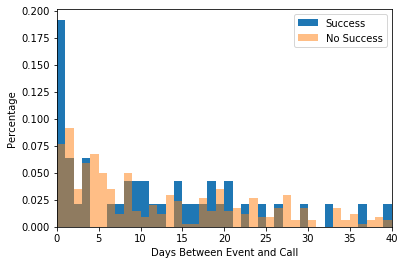

In [290]:
plt.hist(call_events.loc[call_events.picked_up_call == 1,"date_difference"], label = "Success",bins = range(0,60,1), normed = True)
plt.hist(call_events.loc[call_events.picked_up_call == 0,"date_difference"], label = "No Success",bins = range(0,60,1), normed = True,alpha =0.5)
plt.legend()
plt.xlabel("Days Between Event and Call")
plt.ylabel("Percentage")
plt.xlim(0,40)
plt.show()

### Selecting Columns

In [245]:
call_events.columns

Index(['contact_id', 'total_no_success', 'total_success', 'total_calls_count',
       'most_recent_call', 'attended_event', 'attended_webinar', 'email_click',
       'email_open', 'form_fill', 'known_web_visit', 'total_activity_count',
       'most_recent_date', 'picked_up_call', 'most_recent_event_month',
       'most_recent_event_dayofweek', 'most_recent_event_week',
       'most_recent_event_day', 'most_recent_call_month',
       'most_recent_call_dayofweek', 'most_recent_call_week',
       'most_recent_call_day', 'most_recent_call_hour',
       'most_recent_call_minute', 'date_difference'],
      dtype='object')

In [246]:
selected_columns = ['date_difference', 'most_recent_event_dayofweek', 'most_recent_call_day', 
                    'most_recent_call_dayofweek', 'total_activity_count', 'total_calls_count']


In [247]:
def select_columns():
    ft = FunctionTransformer(lambda x: x[selected_columns])
    ft.get_feature_names = lambda: selected_columns
    return ft

select_pipeline = make_pipeline(select_columns())
select_pipeline.fit_transform(call_events)

,date_difference,most_recent_event_dayofweek,most_recent_call_day,most_recent_call_dayofweek,total_activity_count,total_calls_count
0,11.834537,Thursday,25,Monday,5.0,1.0
1,0.595544,Tuesday,15,Tuesday,8.0,2.0
2,26.622141,Thursday,10,Tuesday,6.0,2.0
3,44.864201,Monday,18,Wednesday,1.0,1.0
4,23.893727,Saturday,21,Monday,1.0,1.0
...,...,...,...,...,...,...
503,55.843912,Wednesday,10,Tuesday,1.0,1.0
504,40.867708,Friday,25,Wednesday,1.0,1.0
505,2.973808,Saturday,25,Monday,7.0,1.0
506,39.749711,Monday,13,Friday,1.0,2.0


### Column Transform 
#### Numerical

In [248]:
def numerical_transforms():
    return ColumnTransformer([
        ('date_difference', StandardScaler(), ['date_difference']),
#         ('date_difference', KBinsDiscretizer(n_bins=10, encode="ordinal",strategy="quantile"), ['date_difference']),
        ], 
        remainder='passthrough')

num_pipeline = make_pipeline(select_columns(), numerical_transforms())
pd.DataFrame(num_pipeline.fit_transform(call_events), columns=selected_columns).head()

,date_difference,most_recent_event_dayofweek,most_recent_call_day,most_recent_call_dayofweek,total_activity_count,total_calls_count
0,-0.583542,Thursday,25,Monday,5,1
1,-0.819049,Tuesday,15,Tuesday,8,2
2,-0.273675,Thursday,10,Tuesday,6,2
3,0.108578,Monday,18,Wednesday,1,1
4,-0.330848,Saturday,21,Monday,1,1


#### Categorical

In [249]:
def categorical_transforms():
    return ColumnTransformer([
        ('most_recent_event_dayofweek', OneHotEncoder(sparse=False), [list(selected_columns).index('most_recent_event_dayofweek')]),
        ('most_recent_call_dayofweek', OneHotEncoder(sparse=False), [list(selected_columns).index('most_recent_call_dayofweek')]),
        ],
        remainder='passthrough')

# unique_values = pd.unique(call_events.values.ravel()) 

# ohe = OneHotEncoder(categories=[unique_values]*len(call_events), sparse=False)
# encoded = pd.DataFrame(ohe.fit_transform(
#     call_events), columns=ohe.get_feature_names(call_events.columns))

# column_trans = categorical_transforms()
# column_trans.fit_transform(call_events)
full_pipeline = make_pipeline(select_columns(), numerical_transforms(), categorical_transforms())
full_pipeline.fit_transform(call_events)
# pd.DataFrame(full_pipeline.fit_transform(call_events), columns=[]).head()


array([[0.0, 0.0, 0.0, ..., 25, 5.0, 1.0],
       [0.0, 0.0, 0.0, ..., 15, 8.0, 2.0],
       [0.0, 0.0, 0.0, ..., 10, 6.0, 2.0],
       ...,
       [0.0, 0.0, 1.0, ..., 25, 7.0, 1.0],
       [0.0, 1.0, 0.0, ..., 13, 1.0, 2.0],
       [1.0, 0.0, 0.0, ..., 25, 8.0, 1.0]], dtype=object)

# Model Building 1

In [250]:
full_pipeline.fit(call_events)
X = full_pipeline.transform(call_events)

y = call_events['picked_up_call']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
X_validation, X_test, y_validation, y_test = train_test_split(X_test, y_test, test_size=0.34, random_state=42)

# def upsample(X, y):
#     print(y, len(y[~y]))
#     each_ct = len(y[y])
# #     if len(y[~y]) < each_ct:
        
#     assert len(y[~y]) < each_ct
#     X0, y0 = sklearn.utils.resample(X[~y], y[~y], replace=True, n_samples=each_ct)
#     X1, y1 = X[y], y[y]
#     return np.concatenate([X0, X1]), np.concatenate([y0, y1])

# X_train, y_train = upsample(X_train, y_train)
# X_validation, y_validation = upsample(X_validation, y_validation)
# X_test, y_test = upsample(X_test, y_test)


In [251]:
from sklearn.model_selection import cross_val_score
rf = RandomForestClassifier()
rf.fit(X_train, y_train)      
y_prediction = rf.predict(X_validation)  
acc_logreg = sum(y_prediction == y_validation)/len(y_validation)*100 
print('Random Forest validation accuracy:', str(round(acc_logreg,2)),'%')

Random Forest validation accuracy: 86.75 %


# Model Building 2

In [252]:
call_events["most_recent_event_month"] = call_events["most_recent_date"].dt.month
call_events["most_recent_event_dayofweek"] = call_events["most_recent_date"].dt.dayofweek

call_events["most_recent_call_month"] = call_events["most_recent_call"].dt.month
call_events["most_recent_call_dayofweek"] = call_events["most_recent_call"].dt.dayofweek

In [256]:
call_events = call_events.sample(n = len(call_events), random_state = 0)
call_events = call_events.reset_index(drop = True)
test = call_events.sample(frac = 0.3, random_state = 0)
train = call_events.drop(test.index)

print(prevalence(train.picked_up_call.values))
print(prevalence(test.picked_up_call.values))

0.1151685393258427
0.10526315789473684


In [257]:
X_train = train[selected_columns].values
X_valid = test[selected_columns].values
y_train = train["picked_up_call"].values
y_valid = test["picked_up_call"].values

### Train Model 

In [289]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(max_depth = 5, n_estimators=100, random_state = 42)
rf.fit(X_train, y_train)

y_train_preds_prob = rf.predict_proba(X_train)[:,1]
y_valid_preds_prob = rf.predict_proba(X_valid)[:,1]
y_train_preds = rf.predict(X_train)
y_valid_preds = rf.predict(X_valid)
y_valid_preds_prob

array([0.090531  , 0.04110261, 0.05496607, 0.08683944, 0.06736765,
       0.09445913, 0.08397749, 0.10757802, 0.19113221, 0.14728754,
       0.11911066, 0.03043399, 0.10030491, 0.08209021, 0.07411292,
       0.45412148, 0.06928662, 0.06450657, 0.09350532, 0.10457384,
       0.33673947, 0.07055977, 0.17065192, 0.10907592, 0.08482501,
       0.31332846, 0.11142705, 0.24131063, 0.11718642, 0.07775022,
       0.11123795, 0.08147414, 0.07169095, 0.22167317, 0.06731503,
       0.09818195, 0.13802951, 0.20164921, 0.07824509, 0.08127627,
       0.06452389, 0.17091277, 0.10596945, 0.0743589 , 0.11141409,
       0.09199063, 0.04670719, 0.08403273, 0.04670719, 0.58119266,
       0.07866535, 0.10508885, 0.1078307 , 0.11034989, 0.09909011,
       0.07219414, 0.09140723, 0.12158411, 0.16648291, 0.14854416,
       0.07937281, 0.05825444, 0.1084963 , 0.10329804, 0.08636939,
       0.46514176, 0.07496091, 0.10051109, 0.0993088 , 0.06701202,
       0.07063481, 0.04623886, 0.07511854, 0.07198793, 0.06175

In [287]:
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, classification_report

def calc_specificity(y_actual, y_pred, thresh):
 # calculates specificity
 return sum((y_pred < thresh) & (y_actual == 0)) / sum(y_actual == 0)


def print_report(y_actual, y_pred, thresh):
    auc = roc_auc_score(y_actual, y_pred)
    accuracy = accuracy_score(y_actual, (y_pred > thresh))
    recall = recall_score(y_actual, (y_pred > thresh))
    precision = precision_score(y_actual, (y_pred > thresh))
    specificity = calc_specificity(y_actual, y_pred, thresh)
    print("AUC:%.3f"%auc)
    print("accuracy:%.3f"%accuracy)
    print("recall:%.3f"%recall)
    print("precision:%.3f"%precision)
    print("specificity:%.3f"%specificity)
    print("prevalence:%.3f"%prevalence(y_actual))
#     return auc, accuracy, recall, precision, specificity

print_report(y_valid, y_valid_preds_prob, 0.225)


AUC:0.688
accuracy:0.875
recall:0.250
precision:0.364
specificity:0.949
prevalence:0.105


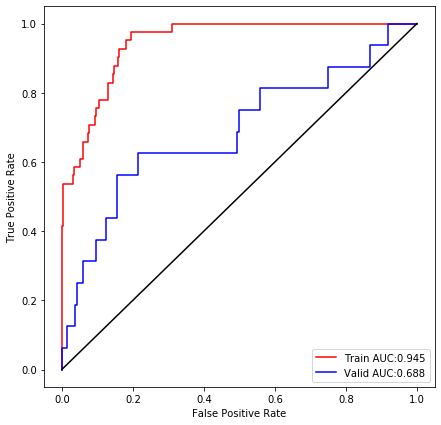

In [288]:
from sklearn.metrics import roc_curve
plt.figure(figsize=(7, 7))
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_preds_prob)
auc_train = roc_auc_score(y_train, y_train_preds_prob)
fpr_valid, tpr_valid, thresholds_valid = roc_curve(y_valid, y_valid_preds_prob)
auc_valid = roc_auc_score(y_valid, y_valid_preds_prob)
plt.plot(fpr_train, tpr_train, "r-",label ="Train AUC:%.3f"%auc_train)
plt.plot(fpr_valid, tpr_valid, "b-",label ="Valid AUC:%.3f"%auc_valid)
plt.plot([0,1],[0,1],"k-")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

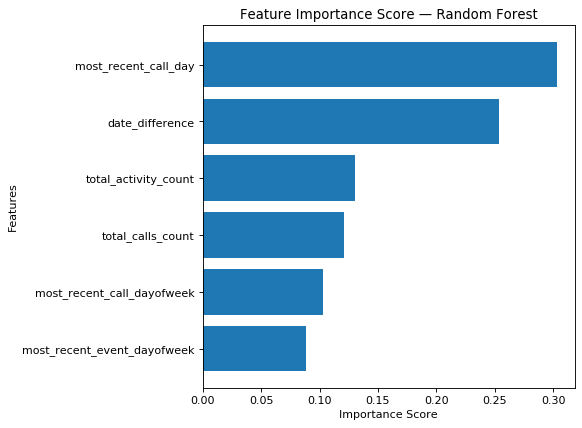

In [279]:
feature_importances = pd.DataFrame(rf.feature_importances_,index = selected_columns,columns=["importance"]).sort_values("importance",ascending=False)
num = min([50,len(selected_columns)])
ylocs = np.arange(num)
# get the feature importance for top num and sort in reverse order
values_to_plot = feature_importances.iloc[:num].values.ravel()[::-1]
feature_labels = list(feature_importances.iloc[:num].index)[::-1]
plt.figure(num=None, figsize=(6, 6), dpi=80, facecolor="w", edgecolor="k");
plt.barh(ylocs, values_to_plot, align = "center")
plt.ylabel("Features")
plt.xlabel("Importance Score")
plt.title("Feature Importance Score — Random Forest")
plt.yticks(ylocs, feature_labels)
plt.show()

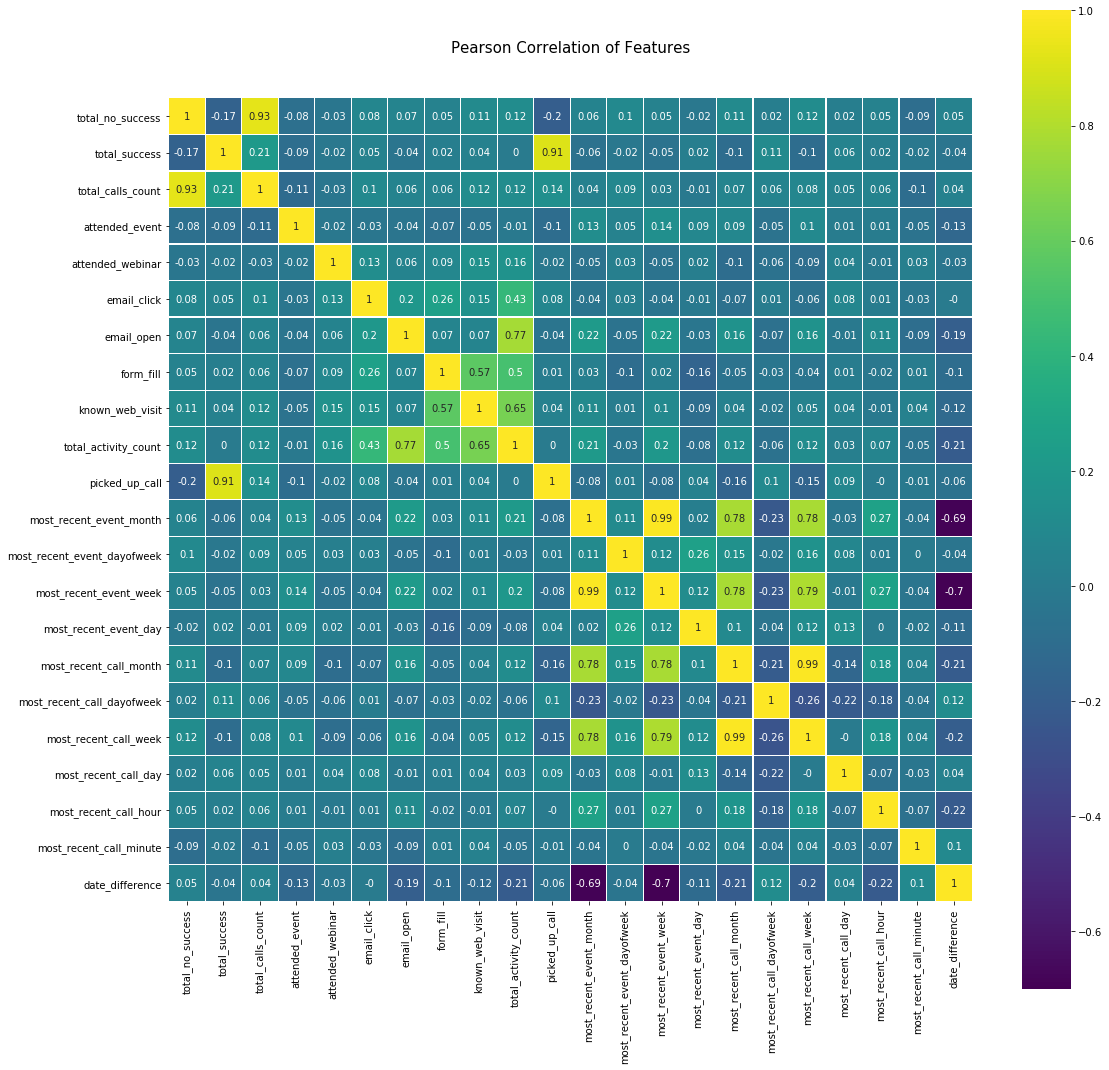

In [178]:
# Plot the correlation between features
colormap=plt.cm.viridis
plt.figure(figsize=(18,18))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(call_events.corr().round(2),
            linewidths=0.1,vmax=1.0, square=True, cmap=colormap, 
            linecolor='white', annot=True);

# Recap: TO DO
- Add in other features like job title and industry to model 
- Balance dataset
- Include SimpleImputater for null values in test set
- try forward and backward feature selection 
- Include cross validation and confusion matrix for testing
- Include regularization, L1 and L2